In [219]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno


from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

import mlflow

from xgboost import XGBRegressor

In [101]:
#%pip install missingno
#%pip install xgboost
#%pip install mlflow

Note: you may need to restart the kernel to use updated packages.


1) Separate the data from the analysis.
2) Be able to automate our analysis. 
3) We want our analysis to be reproducible.

### EDA - Explore properties of dataset

In [153]:
df = pd.read_csv("./data.csv", sep=";")
print(df.shape)
df.head(-1)

(1436, 10)


,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,13500,23,46986,1.0,90,1,0,2000,3,1165
1,13750,23,72937,1.0,90,1,0,2000,3,1165
2,13950,24,41711,1.0,90,1,0,2000,3,1165
3,14950,26,48000,1.0,90,0,0,2000,3,1165
4,13750,30,38500,1.0,90,0,0,2000,3,1170
...,...,...,...,...,...,...,...,...,...,...
1430,8450,80,23000,NaN,86,0,0,1300,3,1015
1431,7500,69,20544,NaN,86,1,0,1300,3,1025
1432,10845,72,19000,NaN,86,0,0,1300,3,1015
1433,8500,71,17016,NaN,86,0,0,1300,3,1015


In [130]:
df.describe()

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
count,1436.000000,1436.000000,1436.000000,414.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000
mean,10730.824513,55.947075,68533.259749,0.173913,101.502089,0.674791,0.055710,1566.827994,4.033426,1072.45961
std,3626.964585,18.599988,37506.448872,0.379493,14.981080,0.468616,0.229441,187.182436,0.952677,52.64112
min,4350.000000,1.000000,1.000000,0.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,1000.00000
25%,8450.000000,44.000000,43000.000000,0.000000,90.000000,0.000000,0.000000,1400.000000,3.000000,1040.00000
50%,9900.000000,61.000000,63389.500000,0.000000,110.000000,1.000000,0.000000,1600.000000,4.000000,1070.00000
75%,11950.000000,70.000000,87020.750000,0.000000,110.000000,1.000000,0.000000,1600.000000,5.000000,1085.00000
max,32500.000000,80.000000,243000.000000,1.000000,192.000000,1.000000,1.000000,2000.000000,5.000000,1615.00000


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y          1436 non-null   int64  
 1   Feature 1  1436 non-null   int64  
 2   Feature 2  1436 non-null   int64  
 3   Feature 3  414 non-null    float64
 4   Feature 4  1436 non-null   int64  
 5   Feature 5  1436 non-null   int64  
 6   Feature 6  1436 non-null   int64  
 7   Feature 7  1436 non-null   int64  
 8   Feature 8  1436 non-null   int64  
 9   Feature 9  1436 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 112.3 KB


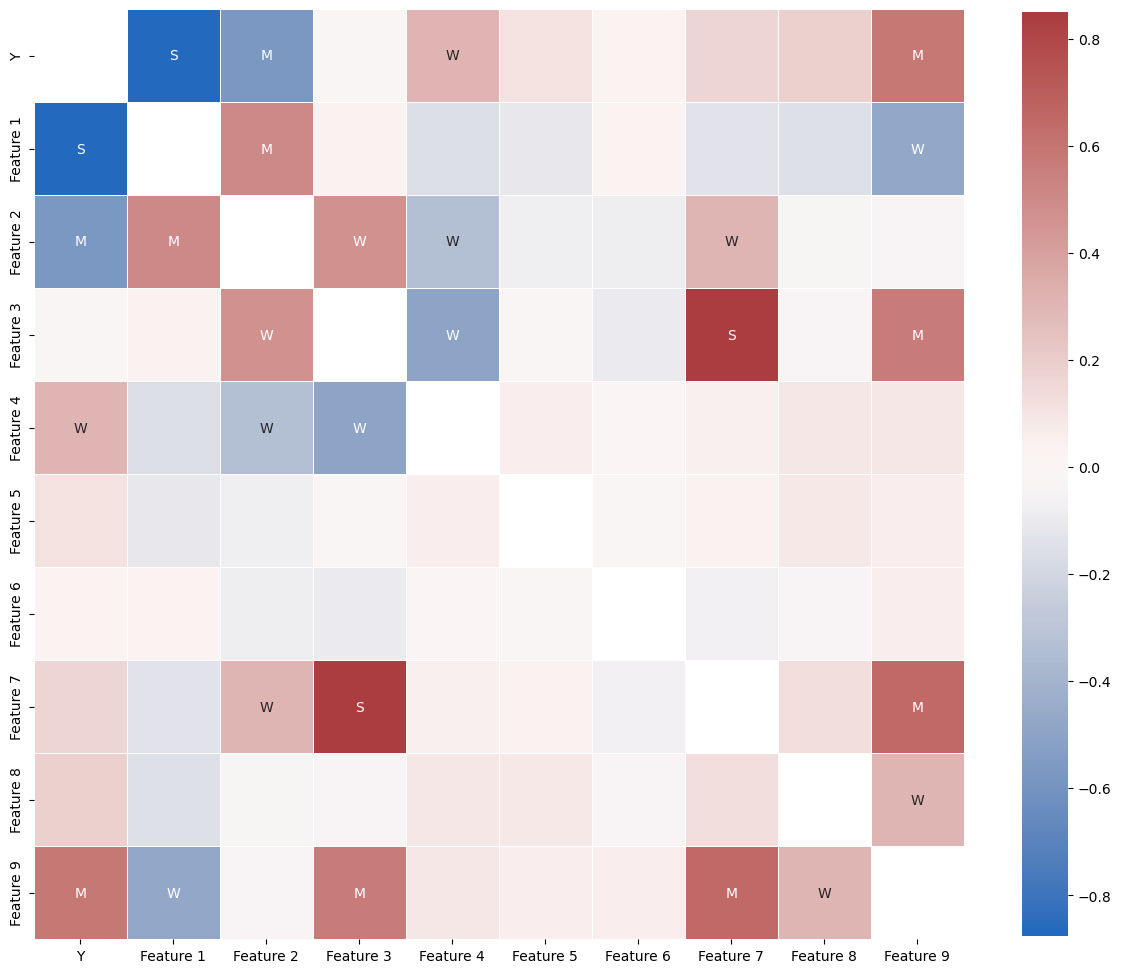

In [135]:
# Create labels for the correlation matrix
df_corr = df.corr(method="pearson")
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

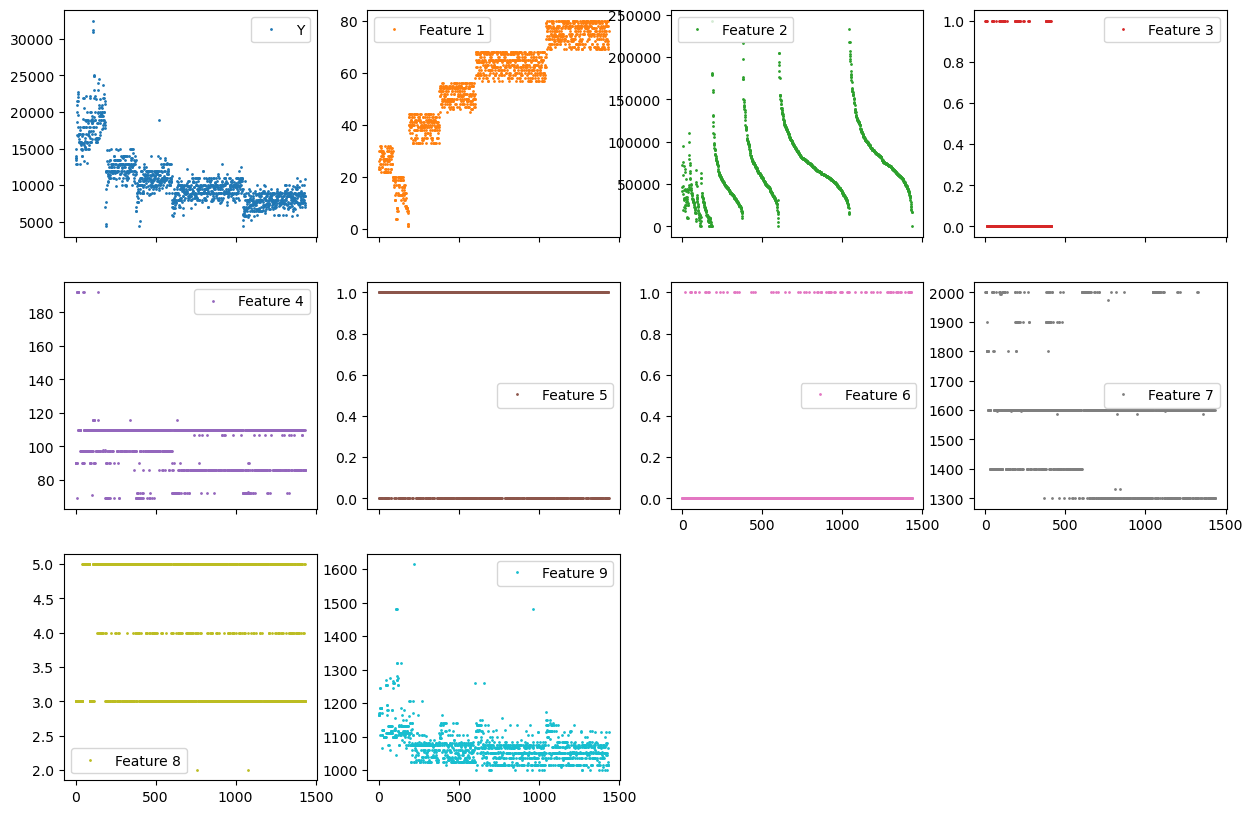

In [136]:
df.plot(lw=0, marker='.', subplots=True, layout=(-1,4), figsize=(15,10), markersize=2);


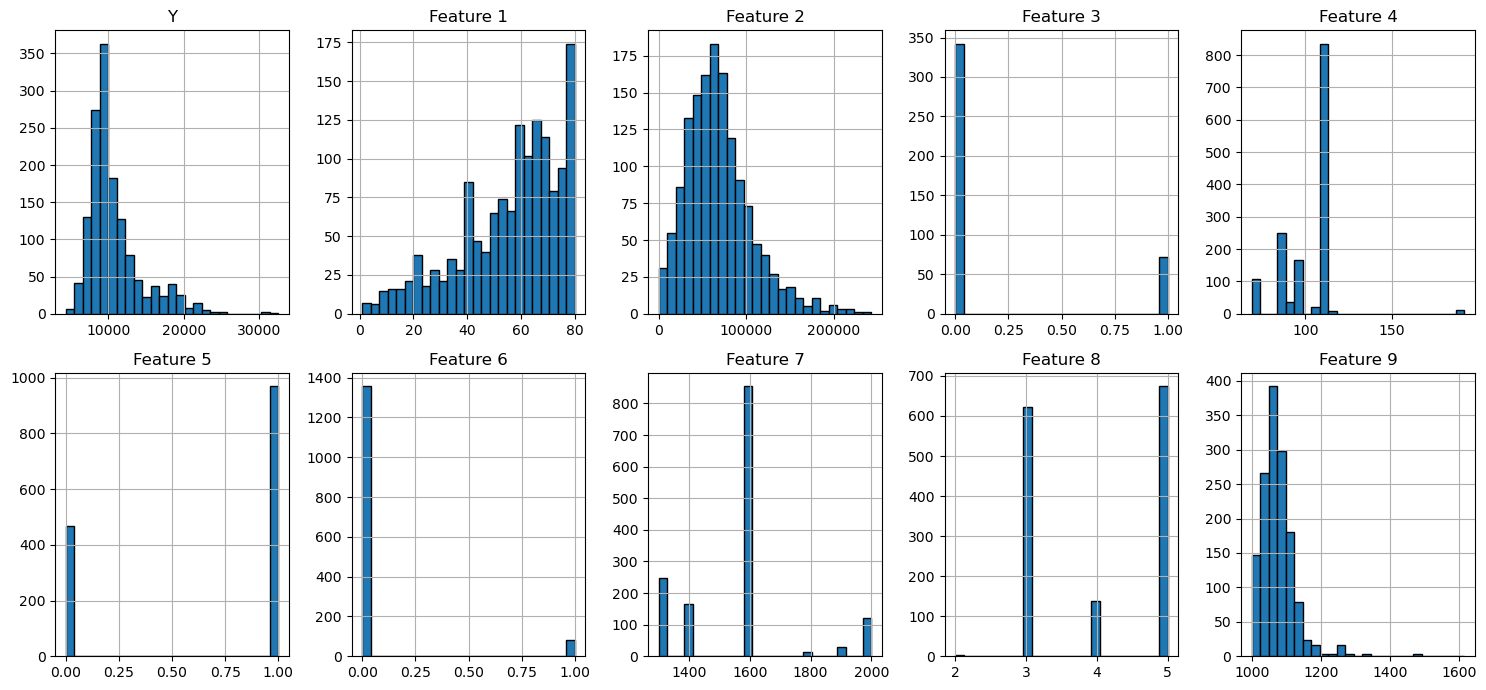

In [137]:
df.hist(bins=25, figsize=(15,7), layout=(-1,5), edgecolor="black")
plt.tight_layout();

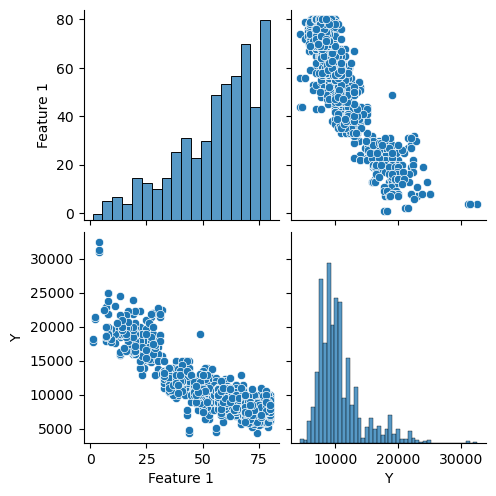

In [139]:
sns.pairplot(df[["Feature 1", "Y"]]);

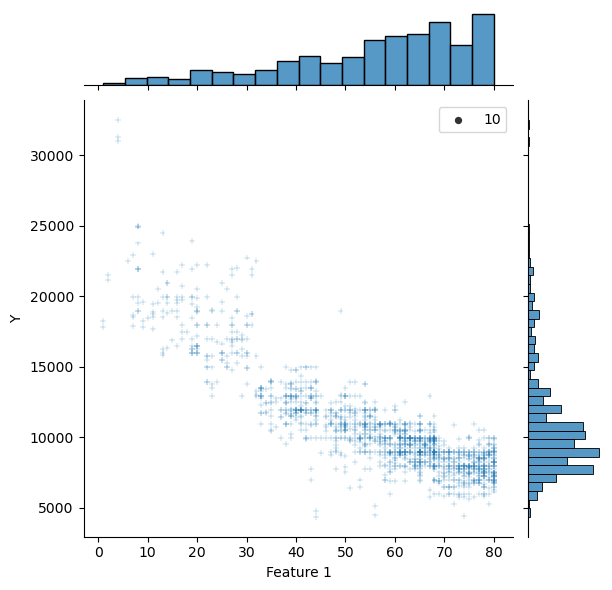

In [141]:
sns.jointplot(x='Feature 1',y='Y', data=df, size=10, alpha=.5, marker='+');

### Structure of numerical features

Feature 3       2
Feature 5       2
Feature 6       2
Feature 8       4
Feature 4      12
Feature 7      12
Feature 9      59
Feature 1      77
Y             236
Feature 2    1263
dtype: int64


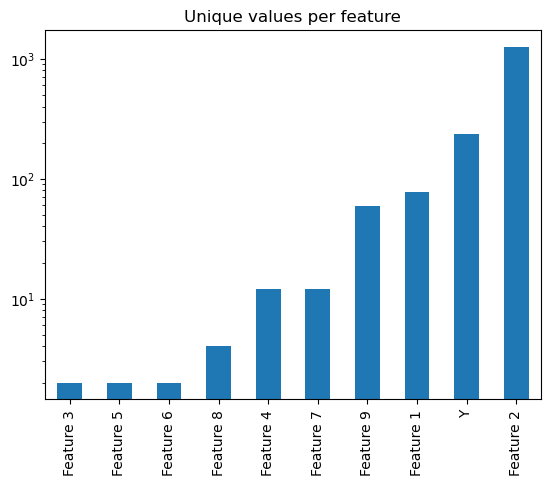

In [142]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()

print(unique_values)
unique_values.plot.bar(logy=True, title="Unique values per feature");

### Quality of features

- Duplicates, missing values, outliers

In [143]:
# Missing values
missing_values = df.isna().sum()
ratio_missing_values = df.isna().mean().sort_values()
print(missing_values)
print(ratio_missing_values)

Y               0
Feature 1       0
Feature 2       0
Feature 3    1022
Feature 4       0
Feature 5       0
Feature 6       0
Feature 7       0
Feature 8       0
Feature 9       0
dtype: int64
Y            0.000000
Feature 1    0.000000
Feature 2    0.000000
Feature 4    0.000000
Feature 5    0.000000
Feature 6    0.000000
Feature 7    0.000000
Feature 8    0.000000
Feature 9    0.000000
Feature 3    0.711699
dtype: float64


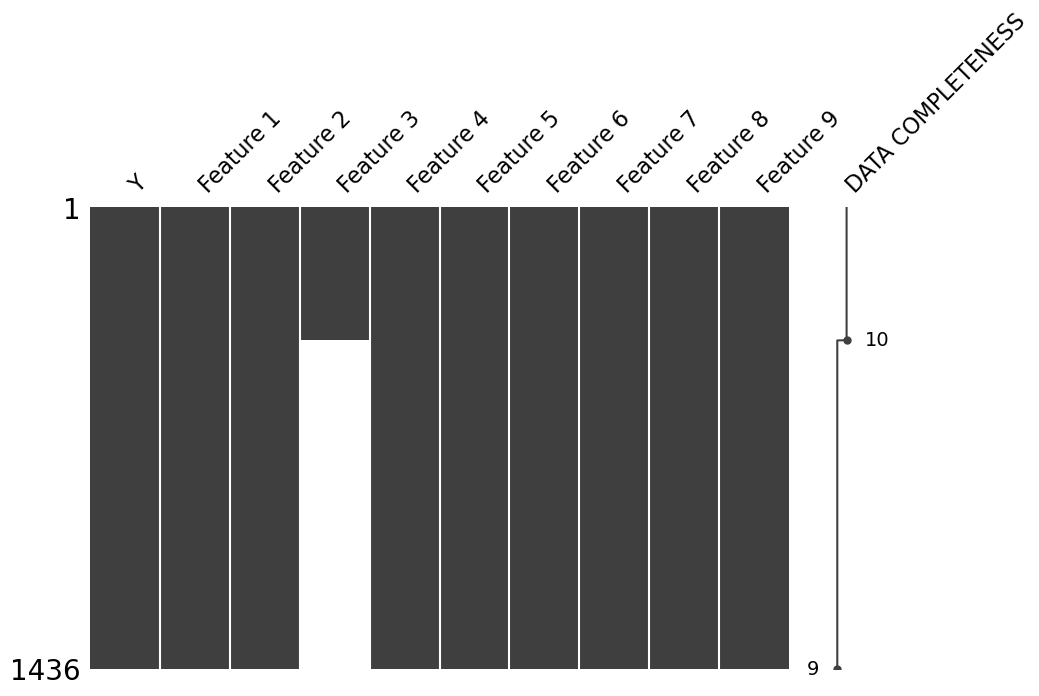

In [150]:
msno.matrix(df, labels=True, sort="descending",figsize=(10,6));

### Data Cleaning

In [154]:
# Drop column feature 3
print(df.shape)
df = df.drop('Feature 3', axis=1)
# Drop duplicates
df = df.drop_duplicates(keep='first')
print(df.shape)

(1436, 10)
(1435, 9)


In [156]:
# Filter outliers using 0.5, 99 percentile
df = df[df['Y'] > np.percentile(df['Y'], q=0.5)]
df = df[df['Y'] <= np.percentile(df['Y'], q=99)]
print(df.shape)

(1383, 9)


### Build Data Pipeline

In [186]:
def load_data(filename):
    assert os.path.exists(filename), print("Dataset does not exist!")
    delimeter = ";"
    dataf = pd.read_csv(filename, sep=delimeter)
    dataf.columns = dataf.columns.str.lower()
    dataf.columns = dataf.columns.str.replace(" ", "_")
    return dataf 

def select_best_features(dataf, num_features=4):

    dataf = clean_dataset(dataf)
    X = dataf.drop("y", axis=1)
    y = dataf.y
    X_train, _ , y_train, _ = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
    select = SelectKBest(k=num_features)
    selected_features = select.fit(X_train, y_train)
    ix_selected = selected_features.get_support(indices=True)
    col_selected = [X.columns[i] for i in ix_selected]

    return col_selected

def start_pipeline(dataf):
    print("Building Pipeline")
    print("-----------------------------------------------------------------")
    return dataf.copy()
    
def clean_dataset(dataf):

    # drop feature with missing values
    dataf.drop("feature_3", axis=1, inplace=True)
    dataf = dataf.drop_duplicates(keep='first')

    # select best features + target
    #cols = ["y","feature_1","feature_2", "feature_4","feature_9"]
    #dataf = dataf[cols]
    return dataf

def remove_outliers(dataf):
    dataf = dataf[dataf['y'] > np.percentile(dataf['y'], q=0.5)]
    dataf = dataf[dataf['y'] <= np.percentile(dataf['y'], q=99)]
    return dataf

def standard_scale(dataf):
    X = dataf.drop("y", axis=1)
    y = dataf.y
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled) 
    return X, y 
    
def split_data(dataf):
    #X = dataf.drop("y", axis=1)
    #y = dataf.y
    X, y = standard_scale(dataf)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
    return X_train, X_val, y_train, y_val



def build_pipeline(dataf):
    pipeline = (dataf
                .pipe(start_pipeline)
                .pipe(clean_dataset)
                .pipe(remove_outliers)
                .pipe(split_data))
    
    return pipeline

def evaluate_metric(regressor, X_train, X_val, y_train, y_val, error="",  **kwargs):
    model = regressor(**kwargs)
    model.fit(X_train, y_train)
    #joblib.dump(value=model, filename="./Models/random_forest.pkl")
    #mlflow.sklearn.log_model(model, "random_forest_model")
    preds_val = model.predict(X_val)
    if error == "mae":
        mae = mean_absolute_error(y_val, preds_val)
        return(mae)
    else:
        mse = mean_squared_error(y_val, preds_val)
        return(mse)


def save_model(pipeline, file_name):
    joblib.dump(pipeline, file_name)

def load_model(file_name):
    return joblib.load(file_name)
    
# Utility functions
def read_test_result(cv_dict, cv=5):
    dic = dict()
    for key in cv_dict.keys():
        if key.startswith('test'):
            dic['Average {}-fold '.format(cv)+key] = cv_dict[key].mean()
            # print('Average {}-fold '.format(cv)+key)
            # print(cv_dict[key].mean())
    
    print(pd.DataFrame(cv_dict).head(20))
    return(dic)


### Model Building

In [187]:
df = load_data(filename="data.csv")
num_leaf_nodes = np.arange(10,200,10)
regressor = RandomForestRegressor
metric_name = "mae"
X_train, X_val, y_train, y_val = build_pipeline(df)

Building Pipeline
-----------------------------------------------------------------


In [192]:
scoring_metrics = ('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
folds_5 = KFold(n_splits=5, shuffle=True, random_state=42)

### LinearRegression

In [218]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
lr_mae = evaluate_metric(LinearRegression, X_train, X_val, y_train, y_val, error=metric_name)
print(f"MAE: {round(lr_mae,2)}")
print("-------------------------------------------------------")
print("Cross Validation")
lr_scores = cross_validate(regressor, X, y, cv=folds_5, scoring=scoring_metrics)
lr_dict = read_test_result(lr_scores)

MAE: 891.87
-------------------------------------------------------
Cross Validation
   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.003999    0.002995  0.850607                -1.993321e+06   
1  0.008001    0.002997  0.848227                -1.810824e+06   
2  0.002003    0.002998  0.871658                -1.896314e+06   
3  0.003013    0.002998  0.864788                -1.776296e+06   
4  0.009001    0.009001  0.854935                -1.755937e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                  -1001.201747                      -1411.850209  
1                  -1024.940111                      -1345.668588  
2                  -1051.728162                      -1377.067127  
3                   -952.007811                      -1332.777392  
4                   -991.255465                      -1325.117781  


### XgBoostRegression

In [217]:
regressor = XGBRegressor()
regressor.fit(X_train, y_train)
xgb_mae = evaluate_metric(XGBRegressor, X_train, X_val, y_train, y_val, error=metric_name)
print(f"MAE: {round(xgb_mae,2)}")
print("-------------------------------------------------------")
print("Cross Validation")
xgb_scores = cross_validate(regressor, X, y, cv=folds_5, scoring=scoring_metrics)
xgb_dict = read_test_result(xgb_scores)

MAE: 847.4
-------------------------------------------------------
Cross Validation
   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.164000    0.008022  0.910544                -1.193597e+06   
1  0.188165    0.008011  0.889989                -1.312557e+06   
2  0.145999    0.007002  0.889719                -1.629462e+06   
3  0.147001    0.005000  0.910973                -1.169549e+06   
4  0.143997    0.006001  0.889294                -1.340036e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -866.462665                      -1092.518649  
1                   -875.120708                      -1145.668725  
2                   -941.150442                      -1276.503835  
3                   -780.047780                      -1081.456697  
4                   -880.065823                      -1157.599204  


### RandomForestRegression

In [224]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
forest_mae = evaluate_metric(RandomForestRegressor, X_train, X_val, y_train, y_val, error=metric_name, max_leaf_nodes=80)
print(f"MAE: {round(forest_mae,2)}")
print("-------------------------------------------------------")
print("Cross Validation")
forest_scores = cross_validate(regressor, X, y, cv=folds_5, scoring=scoring_metrics)
forest_dict = read_test_result(forest_scores)

MAE: 750.46
-------------------------------------------------------
Cross Validation
   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.786609    0.021996  0.910565                -1.193312e+06   
1  0.811790    0.019999  0.892918                -1.277615e+06   
2  0.585818    0.018997  0.899848                -1.479802e+06   
3  0.696386    0.020036  0.917007                -1.090281e+06   
4  0.579917    0.016997  0.902667                -1.178163e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -838.023507                      -1092.388298  
1                   -890.145598                      -1130.316341  
2                   -915.190964                      -1216.471030  
3                   -772.210604                      -1044.165310  
4                   -815.803912                      -1085.432195  


In [214]:
regressor = RandomForestRegressor
metric_list = []
for nodes in num_leaf_nodes:
    metric = evaluate_metric(regressor, X_train, X_val, y_train, y_val, error=metric_name, max_leaf_nodes=nodes)
    print(f" num_leaf_nodes: {nodes} {metric_name.upper()} : {round(metric,2)} with {regressor.__name__} ")
    metric_list.append(metric)
print("-------------------------------------------------------")
print(f"Min MAE: {round(min(metric_list),2)}")

 num_leaf_nodes: 10 MAE : 829.49 with RandomForestRegressor 
 num_leaf_nodes: 20 MAE : 767.23 with RandomForestRegressor 
 num_leaf_nodes: 30 MAE : 748.17 with RandomForestRegressor 
 num_leaf_nodes: 40 MAE : 740.08 with RandomForestRegressor 
 num_leaf_nodes: 50 MAE : 746.28 with RandomForestRegressor 
 num_leaf_nodes: 60 MAE : 747.52 with RandomForestRegressor 
 num_leaf_nodes: 70 MAE : 737.48 with RandomForestRegressor 
 num_leaf_nodes: 80 MAE : 742.18 with RandomForestRegressor 
 num_leaf_nodes: 90 MAE : 748.49 with RandomForestRegressor 
 num_leaf_nodes: 100 MAE : 748.7 with RandomForestRegressor 
 num_leaf_nodes: 110 MAE : 753.92 with RandomForestRegressor 
 num_leaf_nodes: 120 MAE : 752.15 with RandomForestRegressor 
 num_leaf_nodes: 130 MAE : 748.7 with RandomForestRegressor 
 num_leaf_nodes: 140 MAE : 765.53 with RandomForestRegressor 
 num_leaf_nodes: 150 MAE : 759.18 with RandomForestRegressor 
 num_leaf_nodes: 160 MAE : 765.84 with RandomForestRegressor 
 num_leaf_nodes: 17

In [223]:
regressor = ElasticNet()
regressor.fit(X_train, y_train)
elastic_net_mae = evaluate_metric(ElasticNet, X_train, X_val, y_train, y_val, error=metric_name)
print(f"MAE: {round(elastic_net_mae,2)}")
print("-------------------------------------------------------")
print("Cross Validation")
elastic_net_scores = cross_validate(regressor, X, y, cv=folds_5, scoring=scoring_metrics)
elastic_net_dict = read_test_result(elastic_net_scores)

MAE: 894.83
-------------------------------------------------------
Cross Validation
   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.004034    0.002964  0.850489                -1.994892e+06   
1  0.003000    0.001999  0.848354                -1.809308e+06   
2  0.006049    0.004950  0.871719                -1.895420e+06   
3  0.002964    0.004000  0.864726                -1.777105e+06   
4  0.004992    0.003036  0.854911                -1.756231e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                  -1001.069325                      -1412.406463  
1                  -1023.908111                      -1345.105351  
2                  -1051.343429                      -1376.742510  
3                   -952.228672                      -1333.080864  
4                   -990.789919                      -1325.228741  


In [232]:
metric_df = pd.DataFrame([lr_dict, elastic_net_dict ,xgb_dict, forest_dict])
metric_df['Model name'] = ['Linear Regression','Elastic Net','XGBoost', 'Random Forest']
metric_df.set_index('Model name', inplace=True)
# metric_df.to_csv('Minmax_scaling.csv')
metric_df.head()

,Average 5-fold test_r2,Average 5-fold test_neg_mean_squared_error,Average 5-fold test_neg_mean_absolute_error,Average 5-fold test_neg_root_mean_squared_error
Model name,,,,
Linear Regression,0.858043,-1.846538e+06,-1004.226659,-1358.496220
Elastic Net,0.858040,-1.846591e+06,-1003.867891,-1358.512786
XGBoost,0.898104,-1.329040e+06,-868.569483,-1150.749422
Random Forest,0.904601,-1.243835e+06,-846.274917,-1113.754635


In [233]:
metric_df = pd.DataFrame()
metric_df["MAE"] = [lr_mae, elastic_net_mae, xgb_mae, forest_mae]
metric_df['Model name'] = ['Linear Regression', 'Elastic Net', 'XGBoost', 'Random Forest' ]
metric_df.set_index('Model name', inplace=True)
# metric_df.to_csv('Minmax_scaling.csv')
metric_df.head()

,MAE
Model name,
Linear Regression,891.865190
Elastic Net,894.830317
XGBoost,847.404753
Random Forest,750.457075


### Comments

1)

### Mlflow Example Usage

In [ ]:
# Example usage
if __name__ == "__main__":
    df = load_data(filename="data.csv")
    regressor = RandomForestRegressor
    metric_name = "mae"
    X_train, X_val, y_train, y_val = build_pipeline(df)
    nodes = 50
    num_features = len(select_best_features(df))
    
    with mlflow.start_run():
        mlflow.log_param("num_features", num_features)
        mlflow.log_param("regressor", "RandomForestRegressor")
        mae = evaluate_metric(regressor, X_train, X_val, y_train, y_val, error="mae", n_estimators=100, max_leaf_nodes=nodes)
        mlflow.log_param("Mean Absolute Error", mae)
        print("MAE:", mae)

#run mlflow server
!mlflow ui


In [87]:
def select_best_features(dataf, num_features=4):

    dataf = clean_dataset(dataf)
    X = dataf.drop("y", axis=1)
    y = dataf.y
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
    select = SelectKBest(k=num_features)
    selected_features = select.fit(X_train, y_train)
    ix_selected = selected_features.get_support(indices=True)
    col_selected = [X.columns[i] for i in ix_selected]

    return col_selected

df = load_data("data.csv")
best_features = select_best_features(df)
best_features

['feature_1', 'feature_2', 'feature_4', 'feature_9']

Feature 6    0.944290
Feature 5    0.674791
Feature 7    0.589136
Feature 4    0.581476
Feature 8    0.469359
dtype: float64

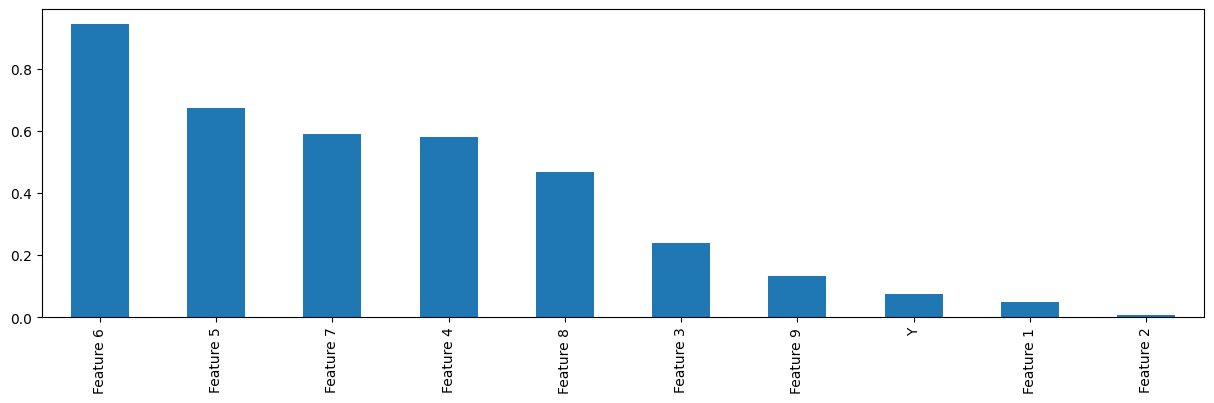

In [43]:
most_frequent_entry = df.mode()

# Checks for each entry if it contains the most frequent entry
df_freq = df.eq(most_frequent_entry.values, axis=1)

# Computes the mean of the 'is_most_frequent' occurrence
df_freq = df_freq.mean().sort_values(ascending=False)

# Show the 5 top features with the highest ratio of singular value content
display(df_freq.head())

# Visualize the 'df_freq' table
df_freq.plot.bar(figsize=(15, 4));

In [46]:
# Handling continuous features

cols_continuous = df.select_dtypes(include="number").nunique() > 12
df_continuous = df[cols_continuous[cols_continuous].index]
df_continuous.shape

(1436, 4)

/home/codespace/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


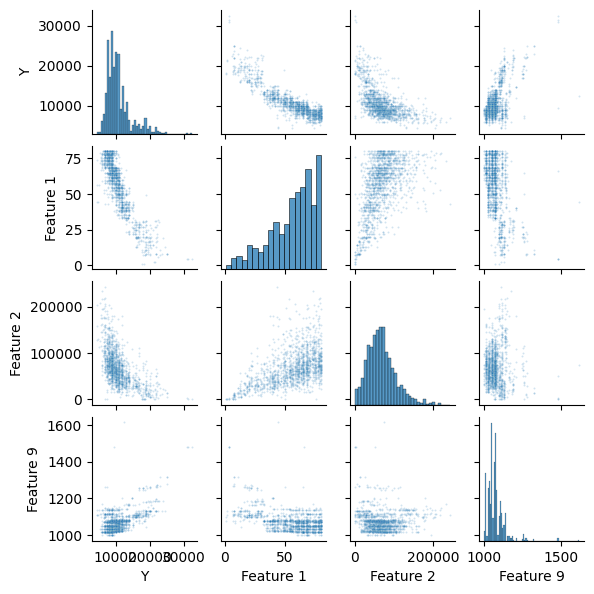

In [47]:
sns.pairplot(df_continuous, height=1.5, plot_kws={"s": 2, "alpha": 0.2});

In [ ]:
df = load_data(filename="data.csv")
df = clean_dataset(df)

start = 92
end = 96
#df = df.drop("y", axis=1)
ll = df[start:end].values.tolist()

df[start:end]